# VAE from scartch on MNIST
--- 

- Author : Tariq Chellali
- Update date: 12/02/2024

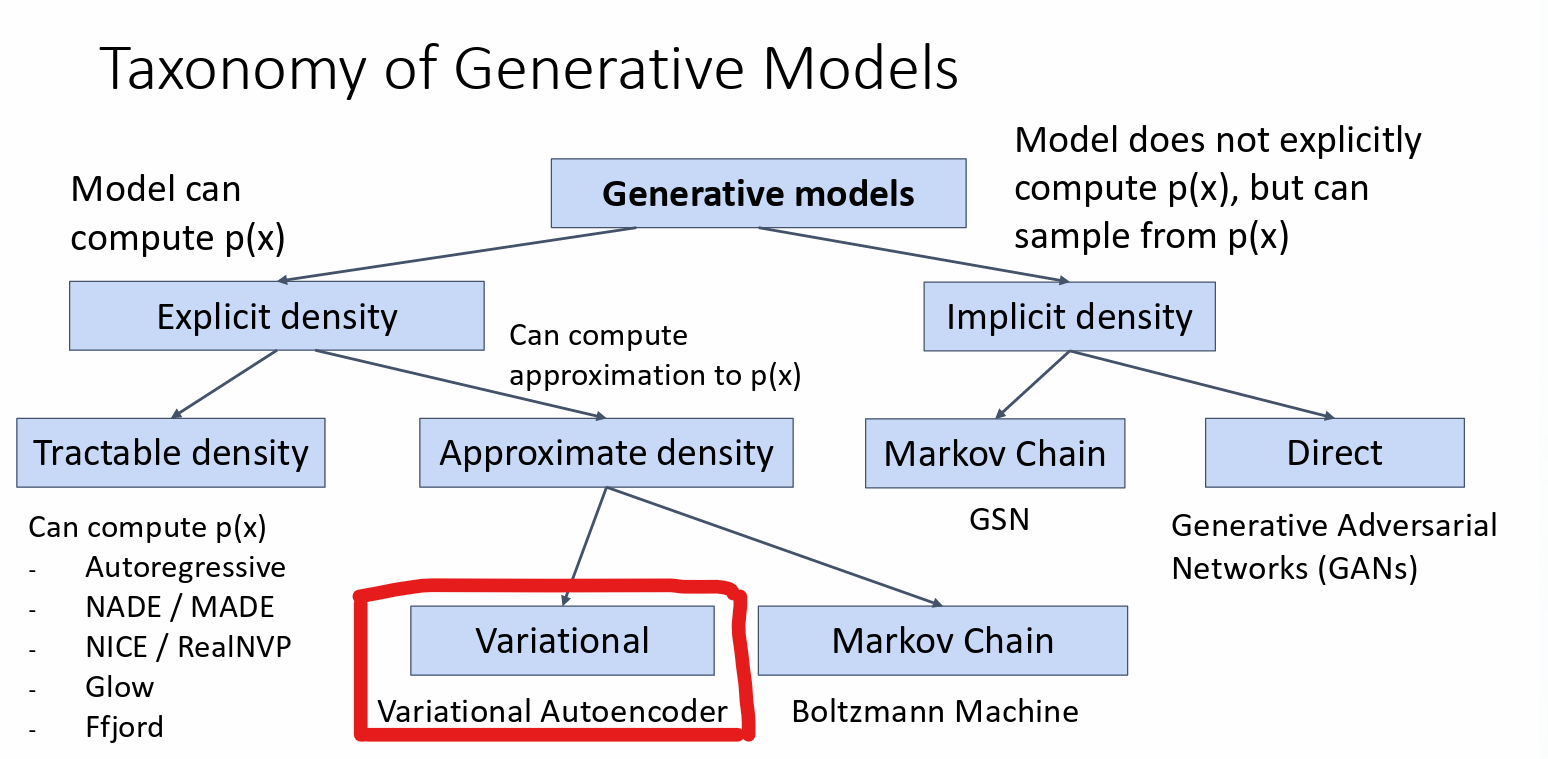

- Variational autoencoder are a type of genralive model that aims at expressing the density probability function to  be learned from the input data. 
- They have an encoder and a decoder architecture
- The encoder aims at transforming the input data and output it's probability distribution in a latent space
- The decoder sample from the distritbution to generate new data


- Dans les autoencodeurs variationnels (VAEs), on ne calcule pas explicitement la densité de probabilité des données (comme dans les modèles autorégressifs), mais on travaille avec une approximation de cette densité, et on maximise une borne inférieure sur cette densité, appelée la borne inférieure de l'évidence (Evidence Lower Bound, ELBO).

Voici comment cela fonctionne de manière plus détaillée :



1. **Calcul de l'ELBO :**
   - L'objectif de l'apprentissage dans un VAE est de maximiser la probabilité marginale des données (la densité de probabilité des données observées). Cependant, calculer cette probabilité exacte est souvent difficile.

   - À la place, on maximise l'ELBO, qui est une borne inférieure de la probabilité marginale. L'ELBO est défini comme suit :

    $\[ \text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - \text{KL}(q(z|x) || p(z)) \]$

   - où :
     - $\(q(z|x)\)$ est la distribution postérieure approximative dans l'espace latent, calculée par l'encodeur.
     - $\(\log p(x|z)\)$ est le terme de reconstruction, mesurant à quel point le modèle est capable de reproduire les données d'entrée.
     - $\(\text{KL}(q(z|x) || p(z))\)$ est la divergence de Kullback-Leibler (KL) entre la distribution postérieure approximative et la distribution a priori dans l'espace latent. Cela régularise l'espace latent.

2. **Échantillonnage Stochastique :**
   - Un aspect clé des VAEs est l'échantillonnage stochastique lors de l'entraînement. Cela signifie que, pendant la phase de rétropropagation du gradient, on échantillonne des exemples dans l'espace latent pour estimer les termes d'espérance dans l'ELBO.

3. **Approximation de la Distribution Postérieure :**
   - La distribution postérieure $\(q(z|x)\)$ est souvent choisie comme une distribution paramétrique (par exemple, une distribution normale multivariée), et son ajustement pendant l'entraînement permet d'approximer la vraie distribution postérieure.

Ainsi, les VAEs optimisent l'ELBO pour apprendre une représentation latente des données. C'est une manière élégante de traiter des distributions de probabilité complexes en travaillant avec une approximation et en introduisant une régularisation qui favorise une meilleure structuration de l'espace latent.


## Importing Libraries

In [2]:
import torch
from torch import nn

## VAE Model

L'architecture du Variational Autoencoder (VAE) dans ce code est relativement simple et se compose de deux parties principales : l'encodeur et le décodeur.

1. **Encodeur :**
   - Une couche linéaire (`img_2hid`) qui transforme l'entrée (`x`) vers un espace caché (`h_dim`) suivi d'une fonction d'activation ReLU.
   - Deux couches linéaires (`hid_2mu` et `hid_2sigma`) qui transforment l'espace caché en la moyenne (`mu`) et l'écart-type (`sigma`) de la distribution latente.

2. **Décodeur :**
   - Une couche linéaire (`z_2hid`) qui transforme la variable latente (`z`) vers l'espace caché, suivie d'une fonction d'activation ReLU.
   - Une couche linéaire (`hid_2img`) qui transforme l'espace caché en une reconstruction de l'entrée, suivie de la fonction d'activation sigmoïde pour normaliser les valeurs des pixels entre 0 et 1.

En résumé, l'encodeur prend l'entrée et la transforme en une distribution latente (représentée par sa moyenne et son écart-type), tandis que le décodeur prend une variable latente et la reconstruit en sortie. Le modèle est formé pour minimiser la différence entre l'entrée originale et sa reconstruction, tout en régularisant la distribution latente pour qu'elle ressemble à une distribution normale standard.

L'architecture est contrôlée par les paramètres suivants :
- `input_dim` : La dimension de l'entrée.
- `h_dim` : La dimension de l'espace caché.
- `z_dim` : La dimension de la variable latente.

Dans cet exemple, l'architecture est simple, mais elle peut être ajustée en modifiant ces paramètres selon les besoins spécifiques de la tâche ou du jeu de données.

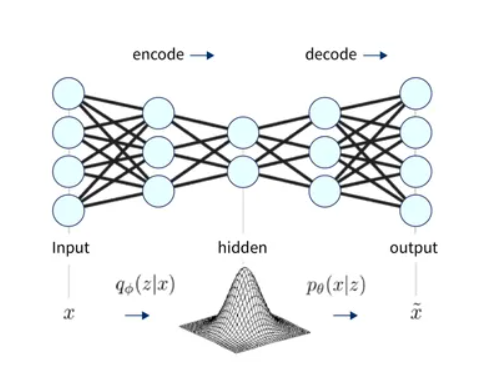

In [3]:
# Définition de la classe VariationalAutoencoder qui hérite de nn.Module
class VariationalAutoencoder(nn.Module):
    # Constructeur de la classe avec les dimensions d'entrée, la dimension cachée h_dim et la dimension latente z_dim
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # Encoder
        # Transformation linéaire de l'espace d'entrée vers l'espace caché
        self.img_2hid = nn.Linear(input_dim, h_dim)
        # Transformation linéaire de l'espace caché vers la moyenne de la distribution latente
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        # Transformation linéaire de l'espace caché vers l'écart-type de la distribution latente
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        # Decoder
        # Transformation linéaire de l'espace latent vers l'espace caché
        self.z_2hid = nn.Linear(z_dim, h_dim)
        # Transformation linéaire de l'espace caché vers l'espace de sortie
        self.hid_2img = nn.Linear(h_dim, input_dim)
        # Fonction d'activation ReLU
        self.relu = nn.ReLU()

    # Fonction pour l'encodage, prenant une entrée x
    def encode(self, x):
        # Transformation linéaire suivie d'une activation ReLU pour l'encoder
        h = self.relu(self.img_2hid(x))
        # Transformation linéaire pour obtenir la moyenne de la distribution latente
        mu = self.hid_2mu(h)
        # Transformation linéaire pour obtenir l'écart-type de la distribution latente
        sigma = self.hid_2sigma(h)
        # Renvoie la moyenne et l'écart-type
        return mu, sigma

    # Fonction pour le décodage, prenant une variable latente z en entrée
    def decode(self, z):
        # Transformation linéaire suivie d'une activation ReLU pour le décodeur
        h = self.relu(self.z_2hid(z))
        # Transformation linéaire pour obtenir les valeurs de pixels reconstruites, normalisées entre 0 et 1
        return torch.sigmoid(self.hid_2img(h))

    # Fonction forward, qui est appelée lors de l'appel de l'instance du modèle
    def forward(self, x):
        # Encodage de l'entrée x pour obtenir la moyenne (mu) et l'écart-type (sigma)
        mu, sigma = self.encode(x)
        # Rééchantillonnage de la variable latente z
        z_reparametrized = mu + sigma * torch.randn_like(sigma)
        # Décodage de la variable latente rééchantillonnée pour obtenir la reconstruction de l'entrée
        x_reconstructed = self.decode(z_reparametrized)
        # Renvoie la reconstruction, la moyenne et l'écart-type
        return x_reconstructed, mu, sigma


- Entrée : 784 neurones
- Couche linéaire de l'encodeur : 200 neurones
- Représentation latente : 20 neurones
- Couche linéaire du décodeur : 200 neurones
- Output du décodeur : 784 neurones

## Test Model with random

In [15]:
x = torch.randn(4,28*28) #  MNIST input image is of size (batch, channels=1, height=28, width=28)
vae = VariationalAutoencoder(input_dim=784)
x_reconstructed,mu,sigma = vae(x)
print(x_reconstructed.shape, mu.shape, sigma.shape)

torch.Size([4, 784]) torch.Size([4, 20]) torch.Size([4, 20])


## Training the model

In [ ]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm # progress bar
from torch import nn , optim
from torchvision import transforms # image augmentation
from torchvision.utils import save_image
from torch.utils.data import DataLoader

## Config

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
BATCH_SIZE = 100
NUM_EPOCHS = 20 
BATCH_SIZE = 64
LR_RATE = 3e-6  # karpathy constant

## Dataset loading

In [ ]:
datasets =datasets.MNIST(root="dataser/", train=True, transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset=datasets, batch_size=BATCH_SIZE, shuffle=True)
model = VariationalAutoencoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum") ## binary cross entropy loss

Binary Cross Entropy Loss. C'est une fonction de perte couramment utilisée pour les tâches de classification binaire. Dans le contexte d'un VAE, la tâche est de reconstruire l'entrée (image MNIST) et BCELoss est utilisée pour mesurer la différence entre la sortie du décodeur (reconstruction) et l'entrée réelle.

## Start Trainning

### DIVERGENCE de Kullback-Leibler (KL) 

La divergence de Kullback-Leibler (KL) mesure la différence entre deux distributions de probabilité. Dans le contexte des Variational Autoencoders (VAEs), la KL est utilisée pour comparer deux distributions : la distribution postérieure $\(q(z | x)\)$ et la distribution a priori $\(p(z)\)$ dans l'espace latent.

- **Distribution Postérieure $\(q(z | x)\)$ :** C'est la distribution des variables latentes $\(z\)$ compte tenu des données d'entrée $\(x\)$. Elle est calculée par l'encodeur du VAE.

- **Distribution a Priori $\(p(z)\)$ :** C'est la distribution a priori des variables latentes. En d'autres termes, c'est l'idée de la distribution que nous souhaitons pour $\(z\)$ avant de voir les données.

La KL mesure à quel point la distribution postérieure ($\(q(z | x)\)$) est différente de la distribution a priori ($\(p(z)\)$). Si la KL est grande, cela signifie que ces deux distributions sont très différentes.

**Objectif de la KL dans les VAEs :**
- L'objectif est d'encourager la distribution postérieure à être similaire à la distribution a priori dans l'espace latent.
- Cela régularise l'espace latent en forçant les représentations des données à suivre une certaine structure ou organisation, plutôt que d'être arbitraires.

**En termes simples :**
- On veut que les $\(z\)$ générés à partir des données d'entrée soient similaires à des $\(z\)$ que nous choisirions même sans avoir vu les données.
- Cela permet au modèle de mieux généraliser et d'apprendre des représentations utiles plutôt que de mémoriser simplement les données d'entraînement.

En résumé, la KL dans les VAEs est une régularisation qui guide le modèle à construire des représentations latentes qui respectent une certaine structure a priori, plutôt que d'être trop spécifiques aux données d'entraînement. Cela aide le modèle à apprendre des représentations générales et à mieux gérer de nouvelles données.

In [54]:
# Boucle d'entraînement sur plusieurs époques
for epoch in range(NUM_EPOCHS):
    # Création d'une barre de progression (tqdm) pour suivre le nombre d'itérations
    loop = tqdm(enumerate(train_loader))
    # Itération sur les données d'entraînement
    for i, (x, _) in loop:
        # Passage en mode GPU (cuda) si disponible, et redimensionnement de l'entrée
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)

        # Forward pass à travers le modèle Variational Autoencoder (VAE)
        x_reconstructed, mu, sigma = model(x)

        # Calcul de la perte de reconstruction (Binary Cross Entropy Loss)
        reconstruction_loss = loss_fn(x_reconstructed, x)
        
        # Calcul de la divergence de Kullback-Leibler (KL) entre la distribution latente et une distribution gaussienne
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Calcul de la perte totale, qui est la somme de la perte de reconstruction et de la divergence KL
        loss = reconstruction_loss + kl_div

        # Réinitialisation des gradients, backpropagation et mise à jour des poids du modèle
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Mise à jour de la barre de progression avec la valeur actuelle de la perte
        loop.set_postfix(loss=loss.item())

1200it [00:33, 36.05it/s, loss=6.94e+10]
1200it [00:35, 34.13it/s, loss=4.38e+10]
1200it [00:46, 26.06it/s, loss=4.92e+10]
1200it [00:33, 35.78it/s, loss=3.4e+10] 
1200it [00:38, 30.78it/s, loss=2.53e+10]
1200it [00:33, 36.34it/s, loss=1.78e+10]
1200it [00:29, 40.11it/s, loss=1.11e+10]
1200it [00:30, 38.77it/s, loss=8.93e+9] 
1200it [00:31, 38.46it/s, loss=5.67e+9]
1200it [00:31, 38.53it/s, loss=3.98e+9]
1200it [00:27, 43.07it/s, loss=2.61e+9]
1200it [00:28, 42.79it/s, loss=1.51e+9]
1200it [00:27, 43.11it/s, loss=7.8e+8] 
1200it [00:27, 43.36it/s, loss=4.07e+8]
1200it [00:27, 43.34it/s, loss=1.55e+8]
1200it [00:28, 42.83it/s, loss=6.37e+7]
1200it [00:25, 47.17it/s, loss=2.16e+7]
1200it [00:24, 48.79it/s, loss=4.67e+6]
1200it [00:24, 48.82it/s, loss=1.3e+6] 
1200it [00:24, 49.56it/s, loss=2.76e+5]


## Inference

In [55]:
model = model.to("cpu")
def inference(digit, num_examples=1):
    """Generate and return `num_examples` images of digit from 0 to 9.
    Args: 
        digit (int): The digit to generate images for ranging from 0 to 9
        num_examples (int): Number of examples/images to generate
    
    Returns:
    A list of `PIL.Image` objects containing the generated images
    """
    images = []
    idx = 0
    for x, y in datasets:
        if y == idx:
            images.append(x)
            idx +=1
        if idx == 10:
            break

    encoding_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1,784))
        encoding_digit.append((mu, sigma))

    mu, sigma = encoding_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon 
        out = model.decode(z)
        out = out.view(-1,1,28,28)
        save_image(out, f"test/generated_[Digit-{digit}]_{example}.png")

In [56]:
for idx in range(10):
    inference(idx, num_examples=1)

Les Variational Autoencoders (VAE) présentent certaines limites, tant du point de vue théorique que pratique. Voici quelques-unes des limites les plus couramment discutées :

### Limites Théoriques :

1. **Approximation de l'inference :** Les VAE reposent sur des approximations pour l'inférence de la distribution latente. L'utilisation de la divergence de Kullback-Leibler (KL) pour mesurer la différence entre la distribution latente et une distribution cible introduit une approximation qui peut ne pas être parfaite.

2. **Hypothèses Gaussiennes :** Les VAE supposent souvent que la distribution latente suit une distribution gaussienne. Cette hypothèse peut ne pas être toujours réaliste pour des données réelles.

3. **Dépendance aux hyperparamètres :** Les performances des VAE peuvent dépendre fortement des choix des hyperparamètres tels que la dimension de la distribution latente, le poids relatif de la divergence KL dans la fonction de perte, etc. Trouver de bons hyperparamètres peut être une tâche délicate.

### Limites Pratiques :

1. **Perte de détails :** Les VAE peuvent avoir tendance à produire des reconstructions lisses et à perdre certains détails fins des données d'entrée. Cela est souvent dû à la régularisation introduite par la divergence KL.

2. **Sensibilité aux paramètres :** La performance des VAE peut être sensible aux choix des paramètres, en particulier en ce qui concerne la dimension de la distribution latente et les termes de régularisation.

3. **Mode Collapse :** Les VAE peuvent être sujets au phénomène de "mode collapse", où le modèle génère des échantillons qui se concentrent sur quelques modes dominants dans les données d'entraînement, ignorant ainsi la diversité des données.

4. **Difficulté de l'apprentissage :** L'apprentissage d'un VAE peut être plus complexe que celui d'autres modèles génératifs, et il peut nécessiter des techniques avancées pour stabiliser l'entraînement.

5. **Interprétabilité Limitée :** Comprendre la signification précise des dimensions latentes peut être difficile, en particulier si la dimension de la distribution latente est élevée.

Malgré ces limites, les VAE restent une méthode puissante pour la génération d'échantillons et l'apprentissage de représentations utiles, notamment en raison de leur capacité à effectuer une régularisation sur la distribution latente et à gérer des données incomplètes. Les recherches en cours visent à atténuer certaines de ces limitations et à explorer des variantes améliorées des VAE.

--------

Pour surmonter les limites des Variational Autoencoders (VAE), différentes approches peuvent être explorées. Voici quelques stratégies couramment utilisées :

### Surmonter les Limites Théoriques :

1. **Variante de la Divergence KL :** Des variantes de la divergence de Kullback-Leibler (KL) peuvent être utilisées pour rendre l'inférence plus précise, par exemple en utilisant une forme analytique lorsque cela est possible.

2. **Distributions Latentes Plus Complexes :** Explorer des distributions latentes plus complexes au lieu de supposer une distribution gaussienne peut aider à mieux modéliser la structure des données. Des distributions latentes plus flexibles peuvent être utilisées, par exemple, en utilisant des distributions multi-modales.

3. **Considération des Dépendances Temporelles :** Pour des données séquentielles, l'extension des VAE pour prendre en compte les dépendances temporelles peut améliorer la modélisation des dynamiques temporelles.

### Surmonter les Limites Pratiques :

1. **Utilisation d'Architectures Plus Complexes :** Des architectures de modèles plus complexes, telles que des VAE hiérarchiques, peuvent être explorées pour capturer des structures plus complexes dans les données.

2. **Augmentation de la Taille de la Distribution Latente :** L'augmentation de la dimension de la distribution latente peut permettre une représentation plus expressive des données, mais cela doit être fait avec prudence pour éviter des problèmes tels que le surajustement.

3. **Techniques d'Entraînement Avancées :** L'utilisation de techniques d'entraînement avancées, telles que l'entraînement adversarial, peut aider à stabiliser l'entraînement et à améliorer la qualité des échantillons générés.

4. **Stratégies de Régularisation Alternatives :** En plus de la divergence KL, d'autres stratégies de régularisation peuvent être explorées pour éviter la perte de détails dans les reconstructions, comme l'utilisation de termes de régularisation spécifiques.

5. **Utilisation de Modèles Génératifs Alternatifs :** En fonction de la tâche, d'autres modèles génératifs tels que les GANs (Generative Adversarial Networks) peuvent être considérés comme une alternative aux VAE, avec leurs avantages et inconvénients propres.

6. **Recherche sur les Hyperparamètres :** La recherche minutieuse des hyperparamètres, y compris la dimension de la distribution latente, le poids relatif de la divergence KL, etc., est cruciale pour obtenir de bonnes performances.

7. **Ensemble de Modèles :** L'utilisation d'ensembles de modèles ou d'approches d'apprentissage en plusieurs étapes peut améliorer la robustesse du modèle et réduire la sensibilité aux choix des hyperparamètres.

En pratique, il n'y a pas de solution unique pour surmonter toutes les limitations, et le choix des stratégies dépend souvent de la tâche spécifique et des caractéristiques des données. Les chercheurs continuent d'explorer de nouvelles variantes et approches pour améliorer la capacité des VAE à modéliser des données complexes.